# Eye State Classification Model v4.0
## Robust Training for Real-World Deployment

### CRITICAL FIX FROM v3:
- **v3 trained WITHOUT CLAHE but inferred WITH CLAHE** = distribution mismatch!
- **v4 applies CLAHE during BOTH training AND inference** = consistent pipeline

### New Augmentations for Real-World Robustness:
1. **Motion blur** - simulates head movement in car
2. **Partial occlusion** - glasses reflections, shadows, hair
3. **Extreme lighting** - dashboard glow, sunlight
4. **Gaussian noise** - camera sensor noise in low light
5. **CLAHE preprocessing** - matches inference pipeline exactly

---
**Author**: Binomial Team  
**Date**: December 2025

## Part 1: Setup & Configuration

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Input, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-12-24 07:28:37.384739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766561317.575646      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766561317.629490      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766561318.091999      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766561318.092056      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766561318.092059      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Keras version: 3.10.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# ============================================
# CONFIGURATION
# ============================================

# Kaggle dataset path - ADJUST IF NEEDED
DATA_DIR = "/kaggle/input/eyestate-yawndrowsiness-dataset/data/eyes"

# Image settings
IMG_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 1)

# Training settings
BATCH_SIZE = 32
EPOCHS = 40
INITIAL_LR = 0.0003

# Class weights (2x penalty for missing closed eyes - safety critical)
CLASS_WEIGHTS = {0: 2.0, 1: 1.0}

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# CLAHE configuration - MUST MATCH INFERENCE!
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_SIZE = (4, 4)

print("Configuration:")
print(f"  Data: {DATA_DIR}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Class weights: {CLASS_WEIGHTS}")

Configuration:
  Data: /kaggle/input/eyestate-yawndrowsiness-dataset/data/eyes
  Batch size: 32
  Class weights: {0: 2.0, 1: 1.0}


## Part 2: Robust Augmentation Functions

In [3]:
# Create CLAHE object once
clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP_LIMIT, tileGridSize=CLAHE_TILE_SIZE)

def apply_clahe(image):
    """Apply CLAHE - CRITICAL for matching inference pipeline."""
    if len(image.shape) == 3:
        image = image[:, :, 0]
    image_uint8 = (image * 255).astype(np.uint8)
    enhanced = clahe.apply(image_uint8)
    return enhanced.astype(np.float32) / 255.0


def add_motion_blur(image, kernel_size=5):
    """Simulate motion blur from head movement."""
    if np.random.random() > 0.3:
        return image
    
    if np.random.random() > 0.5:
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[kernel_size // 2, :] = np.ones(kernel_size) / kernel_size
    else:
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[:, kernel_size // 2] = np.ones(kernel_size) / kernel_size
    
    if len(image.shape) == 3:
        image = image[:, :, 0]
    
    return cv2.filter2D(image, -1, kernel)


def add_partial_occlusion(image, max_coverage=0.15):
    """Simulate glasses reflections, shadows."""
    if np.random.random() > 0.2:
        return image
    
    img = image.copy()
    if len(img.shape) == 3:
        img = img[:, :, 0]
    
    h, w = img.shape
    rect_h = int(h * np.random.uniform(0.05, max_coverage))
    rect_w = int(w * np.random.uniform(0.1, max_coverage * 2))
    
    y = np.random.randint(0, max(1, h - rect_h))
    x = np.random.randint(0, max(1, w - rect_w))
    
    fill_value = np.random.uniform(0, 0.3) if np.random.random() > 0.5 else np.random.uniform(0.7, 1.0)
    img[y:y+rect_h, x:x+rect_w] = fill_value
    
    return img


def add_gaussian_noise(image, std=0.05):
    """Simulate camera sensor noise."""
    if np.random.random() > 0.3:
        return image
    noise = np.random.normal(0, std, image.shape)
    return np.clip(image + noise, 0, 1)


def adjust_brightness_contrast(image, brightness_range=(-0.3, 0.3), contrast_range=(0.7, 1.3)):
    """Random brightness and contrast."""
    brightness = np.random.uniform(*brightness_range)
    contrast = np.random.uniform(*contrast_range)
    return np.clip(image * contrast + brightness, 0, 1)


def random_rotation(image, max_angle=20):
    """Random rotation."""
    angle = np.random.uniform(-max_angle, max_angle)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    if len(image.shape) == 3:
        image = image[:, :, 0]
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)


def random_zoom(image, zoom_range=(0.85, 1.15)):
    """Random zoom."""
    zoom = np.random.uniform(*zoom_range)
    h, w = image.shape[:2]
    if len(image.shape) == 3:
        image = image[:, :, 0]
    
    new_h, new_w = int(h * zoom), int(w * zoom)
    
    if zoom > 1:
        resized = cv2.resize(image, (new_w, new_h))
        start_y = (new_h - h) // 2
        start_x = (new_w - w) // 2
        return resized[start_y:start_y+h, start_x:start_x+w]
    else:
        resized = cv2.resize(image, (new_w, new_h))
        pad_y = (h - new_h) // 2
        pad_x = (w - new_w) // 2
        cropped = np.zeros((h, w), dtype=image.dtype)
        cropped[pad_y:pad_y+new_h, pad_x:pad_x+new_w] = resized
        return cropped

print("✓ Augmentation functions defined")

✓ Augmentation functions defined


In [4]:
def robust_augmentation(image, is_training=True):
    """
    Complete augmentation pipeline.
    CRITICAL: Applies CLAHE to BOTH training AND validation!
    """
    if len(image.shape) == 3:
        img = image[:, :, 0]
    else:
        img = image.copy()
    
    if is_training:
        img = random_rotation(img, max_angle=15)
        img = random_zoom(img, zoom_range=(0.9, 1.1))
        img = adjust_brightness_contrast(img, (-0.2, 0.2), (0.8, 1.2))
        img = add_motion_blur(img, kernel_size=3)
        img = add_gaussian_noise(img, std=0.03)
        img = add_partial_occlusion(img, max_coverage=0.12)
    
    # CLAHE - ALWAYS APPLIED (key fix!)
    img = apply_clahe(img)
    
    return np.expand_dims(img, axis=-1)

print("✓ robust_augmentation() defined")

✓ robust_augmentation() defined


## Part 3: Visualize Augmentations

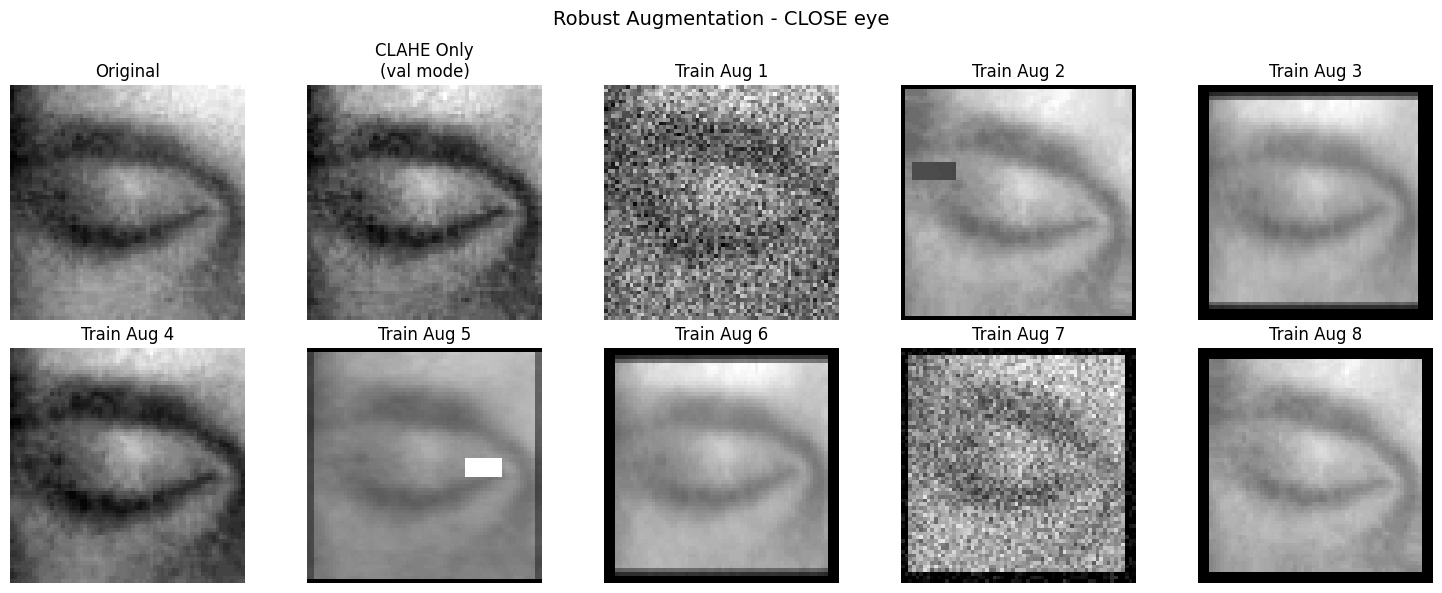

In [5]:
def visualize_augmentations(data_dir):
    """Visualize augmentation pipeline."""
    sample_path = None
    for split in ['train', 'val']:
        for cls in ['Close', 'Open']:  # Fixed: Changed from 'closed', 'open' to match Kaggle dataset
            cls_dir = os.path.join(data_dir, split, cls)
            if os.path.exists(cls_dir):
                files = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png'))]
                if files:
                    sample_path = os.path.join(cls_dir, files[0])
                    sample_class = cls
                    break
        if sample_path:
            break
    
    if not sample_path:
        print("No sample images found!")
        return
    
    original = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    original = cv2.resize(original, IMG_SIZE).astype(np.float32) / 255.0
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    clahe_only = robust_augmentation(original.copy(), is_training=False)
    axes[0, 1].imshow(clahe_only[:, :, 0], cmap='gray')
    axes[0, 1].set_title('CLAHE Only\n(val mode)')
    axes[0, 1].axis('off')
    
    for i in range(8):
        row, col = divmod(i + 2, 5)
        augmented = robust_augmentation(original.copy(), is_training=True)
        axes[row, col].imshow(augmented[:, :, 0], cmap='gray')
        axes[row, col].set_title(f'Train Aug {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle(f'Robust Augmentation - {sample_class.upper()} eye', fontsize=14)
    plt.tight_layout()
    plt.savefig('augmentation_v4.png', dpi=150)
    plt.show()

visualize_augmentations(DATA_DIR)

## Part 4: Data Generator & Loading

In [6]:
class RobustDataGenerator(keras.utils.Sequence):
    """Custom generator with robust augmentation + CLAHE."""
    
    def __init__(self, image_paths, labels, batch_size=32, img_size=(64, 64),
                 augment=True, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_labels = [], []
        
        for idx in batch_indices:
            img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, self.img_size).astype(np.float32) / 255.0
            img = robust_augmentation(img, is_training=self.augment)
            batch_images.append(img)
            batch_labels.append(self.labels[idx])
        
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

print("✓ RobustDataGenerator defined")

✓ RobustDataGenerator defined


In [7]:
def load_dataset(data_dir):
    """Load image paths and labels."""
    class_mapping = {'Close': 0, 'Open': 1}  # Fixed: Changed from 'closed', 'open' to match Kaggle dataset
    results = {}
    
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(data_dir, split)
        if not os.path.exists(split_dir):
            continue
        
        paths, labels = [], []
        for class_name, class_label in class_mapping.items():
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.exists(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_label)
        
        results[split] = (paths, labels)
        print(f"  {split}: {len(paths)} images")
    
    return results.get('train', ([], [])), results.get('val', ([], [])), results.get('test', ([], []))

print("\n" + "="*50)
print("LOADING DATASET")
print("="*50)
(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = load_dataset(DATA_DIR)

print(f"\nClass mapping: Close=0, Open=1")


LOADING DATASET
  train: 53843 images
  val: 17950 images
  test: 17951 images

Class mapping: Close=0, Open=1


In [8]:
# Create generators
train_gen = RobustDataGenerator(train_paths, train_labels, BATCH_SIZE, IMG_SIZE, augment=True)
val_gen = RobustDataGenerator(val_paths, val_labels, BATCH_SIZE, IMG_SIZE, augment=False, shuffle=False)
test_gen = RobustDataGenerator(test_paths, test_labels, BATCH_SIZE, IMG_SIZE, augment=False, shuffle=False)

print(f"✓ Train: {len(train_gen)} batches")
print(f"✓ Val: {len(val_gen)} batches")
print(f"✓ Test: {len(test_gen)} batches")

✓ Train: 1682 batches
✓ Val: 560 batches
✓ Test: 560 batches


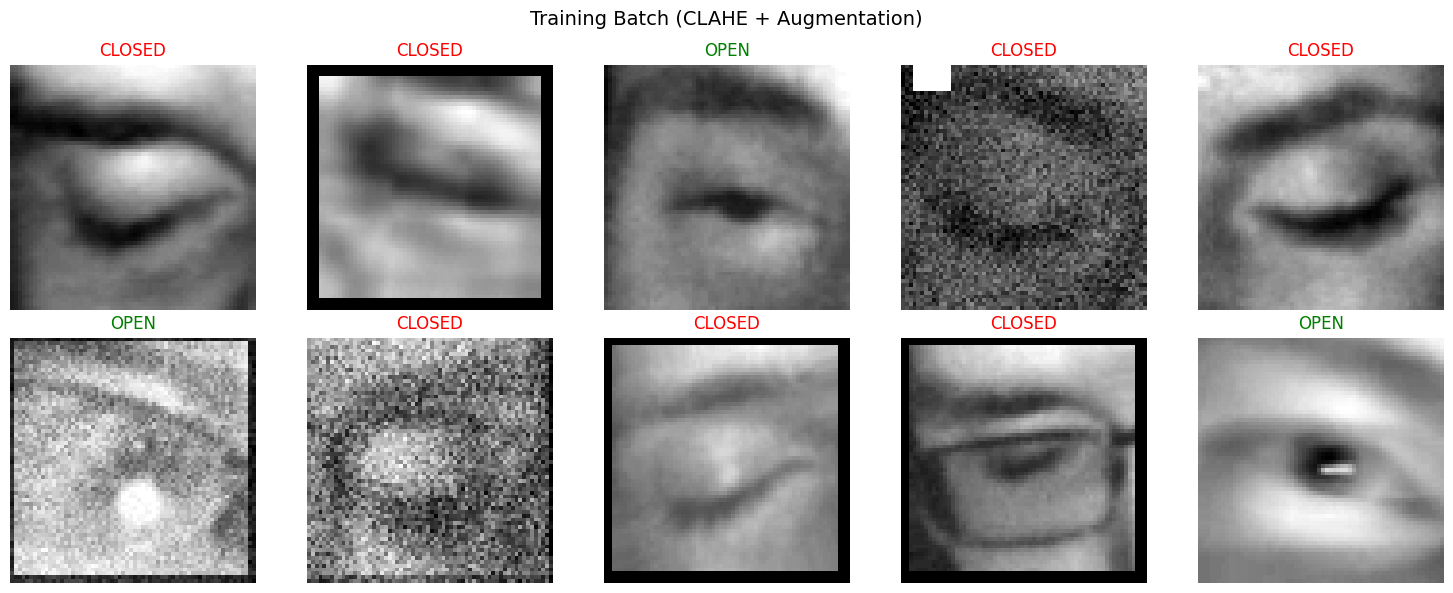

In [9]:
# Visualize training batch
batch_x, batch_y = train_gen[0]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Training Batch (CLAHE + Augmentation)', fontsize=14)

for i in range(min(10, len(batch_x))):
    ax = axes[i // 5, i % 5]
    ax.imshow(batch_x[i].squeeze(), cmap='gray')
    label = 'OPEN' if batch_y[i] == 1 else 'CLOSED'
    ax.set_title(label, color='green' if batch_y[i] == 1 else 'red')
    ax.axis('off')

plt.tight_layout()
plt.savefig('training_batch_v4.png', dpi=150)
plt.show()

## Part 5: Model Architecture

In [10]:
def build_eye_classifier_v4(input_shape=(64, 64, 1)):
    """Same architecture as v3, improved training pipeline."""
    inputs = Input(shape=input_shape)
    
    # Block 1
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 2
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Block 3
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs, name='EyeClassifier_v4_Robust')

model = build_eye_classifier_v4(INPUT_SHAPE)
model.summary()

I0000 00:00:1766561334.513250      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766561334.517172      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "EyeClassifier_v4_Robust"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 313,825 (1.20 MB)

 Trainable params: 312,545 (1.19 MB)

 Non-trainable params: 1,280 (5.00 KB)

## Part 6: Training

In [11]:
class TrainingMonitor(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy', 0)
        train_acc = logs.get('accuracy', 0)
        if epoch > 3 and val_acc < 0.60:
            print(f"\n⚠️ WARNING: val_accuracy={val_acc:.4f}")
        if train_acc - val_acc > 0.15:
            print(f"\n⚠️ Overfitting: gap={train_acc-val_acc:.2f}")

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('eye_state_classifier_v4_best.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    TrainingMonitor()
]

print(f"Optimizer: Adam (lr={INITIAL_LR})")
print(f"Class weights: {CLASS_WEIGHTS}")

Optimizer: Adam (lr=0.0003)
Class weights: {0: 2.0, 1: 1.0}


In [12]:
print("\n" + "="*60)
print("STARTING TRAINING - v4 ROBUST")
print("="*60)
print("Key fix: CLAHE now applied during training!")
print("="*60 + "\n")

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHTS,
    verbose=1
)

print("\n✓ Training complete!")


STARTING TRAINING - v4 ROBUST
Key fix: CLAHE now applied during training!

Epoch 1/40


I0000 00:00:1766561341.268781     158 service.cc:152] XLA service 0x7970dc009740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766561341.268815     158 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766561341.268819     158 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766561342.292971     158 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-24 07:29:04.924366: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-24 07:29:05.065976: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   1/1682 ━━━━━━━━━━━━━━━━━━━━ 6:47:36 15s/step - accuracy: 0.5625 - loss: 1.3396

I0000 00:00:1766561350.887159     158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1682/1682 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5616 - loss: 1.0535
Epoch 1: val_accuracy improved from -inf to 0.82919, saving model to eye_state_classifier_v4_best.keras
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 677s 394ms/step - accuracy: 0.5617 - loss: 1.0534 - val_accuracy: 0.8292 - val_loss: 0.3843 - learning_rate: 3.0000e-04
Epoch 2/40
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8860 - loss: 0.3932
Epoch 2: val_accuracy improved from 0.82919 to 0.94453, saving model to eye_state_classifier_v4_best.keras
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 193s 115ms/step - accuracy: 0.8860 - loss: 0.3932 - val_accuracy: 0.9445 - val_loss: 0.1570 - learning_rate: 3.0000e-04
Epoch 3/40
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9326 - loss: 0.2538
Epoch 3: val_accuracy improved from 0.94453 to 0.97606, saving model to eye_state_classifier_v4_best.keras
1682/1682 ━━━━━━━━━━━━━━━━━━━━ 157s 93ms/step - accuracy: 0.9326 - loss: 0.2538 - val_accuracy: 0.9761 - val_loss: 0.0932 -

## Part 7: Training History

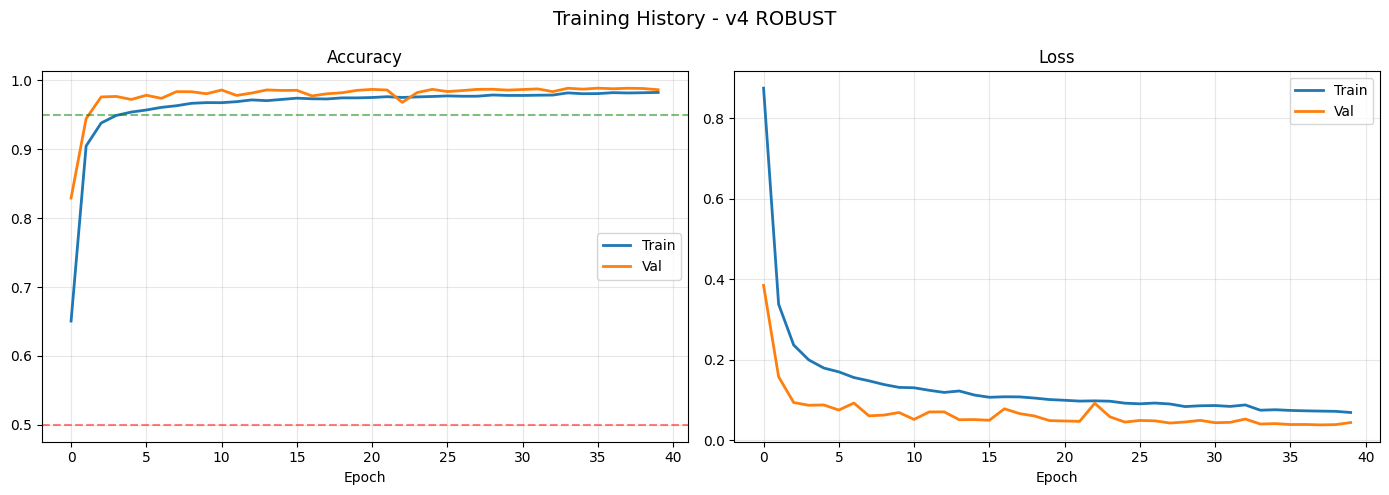

Best Val Accuracy: 98.88%


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2)
axes[0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0].axhline(y=0.95, color='g', linestyle='--', alpha=0.5)
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History - v4 ROBUST', fontsize=14)
plt.tight_layout()
plt.savefig('training_history_v4.png', dpi=150)
plt.show()

print(f"Best Val Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")

## Part 8: Test Evaluation

In [14]:
print("\n" + "="*50)
print("TEST EVALUATION")
print("="*50)

y_pred_proba, y_true = [], []
for i in range(len(test_gen)):
    batch_x, batch_y = test_gen[i]
    pred = model.predict(batch_x, verbose=0)
    y_pred_proba.extend(pred.flatten())
    y_true.extend(batch_y)

y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)
y_pred = (y_pred_proba > 0.5).astype(int)

print(f"\nPrediction variance: {y_pred_proba.std():.4f}")
print(classification_report(y_true, y_pred, target_names=['Closed', 'Open']))


TEST EVALUATION

Prediction variance: 0.4928
              precision    recall  f1-score   support

      Closed       0.99      0.99      0.99      8867
        Open       0.99      0.99      0.99      9053

    accuracy                           0.99     17920
   macro avg       0.99      0.99      0.99     17920
weighted avg       0.99      0.99      0.99     17920



In [15]:
# Safety metrics
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp

closed_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
fnr = fp / (tn + fp) if (tn + fp) > 0 else 1

print("\n" + "="*50)
print("SAFETY METRICS")
print("="*50)
print(f"Closed Eye Recall: {closed_recall*100:.2f}% (Target: >95%)")
print(f"Miss Rate (FNR):   {fnr*100:.2f}% (Target: <5%)")

if closed_recall >= 0.95:
    print("\n✅ SAFETY TARGET MET")
else:
    print(f"\n⚠️ Need {(0.95-closed_recall)*100:.1f}% more recall")


SAFETY METRICS
Closed Eye Recall: 98.83% (Target: >95%)
Miss Rate (FNR):   1.17% (Target: <5%)

✅ SAFETY TARGET MET


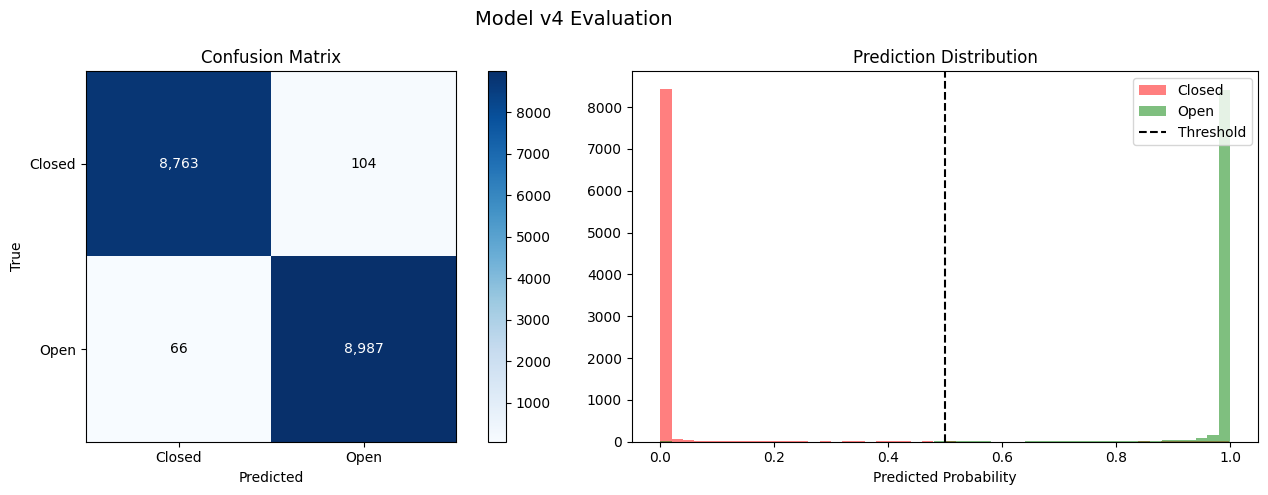

In [16]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
im = axes[0].imshow(cm, cmap='Blues')
axes[0].figure.colorbar(im, ax=axes[0])
axes[0].set(xticks=[0, 1], yticks=[0, 1], xticklabels=['Closed', 'Open'],
           yticklabels=['Closed', 'Open'], ylabel='True', xlabel='Predicted')
for i in range(2):
    for j in range(2):
        axes[0].text(j, i, f'{cm[i, j]:,}', ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')
axes[0].set_title('Confusion Matrix')

# Distribution
axes[1].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='Closed', color='red')
axes[1].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='Open', color='green')
axes[1].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_title('Prediction Distribution')
axes[1].legend()

plt.suptitle('Model v4 Evaluation', fontsize=14)
plt.tight_layout()
plt.savefig('evaluation_v4.png', dpi=150)
plt.show()

## Part 9: Threshold Optimization

In [17]:
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_t = (y_pred_proba > thresh).astype(int)
    cm_t = confusion_matrix(y_true, y_pred_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    acc = (tn_t + tp_t) / (tn_t + fp_t + fn_t + tp_t)
    closed_rec = tn_t / (tn_t + fp_t) if (tn_t + fp_t) > 0 else 0
    results.append({'threshold': thresh, 'accuracy': acc, 'closed_recall': closed_rec})

# Find optimal
best = None
for r in results:
    if r['closed_recall'] >= 0.95 and r['accuracy'] >= 0.85:
        if best is None or r['accuracy'] > best['accuracy']:
            best = r

if best is None:
    best = max(results, key=lambda x: x['closed_recall'] * 0.7 + x['accuracy'] * 0.3)

OPTIMAL_THRESHOLD = best['threshold']
print(f"\n✓ Optimal threshold: {OPTIMAL_THRESHOLD:.2f}")
print(f"  Accuracy: {best['accuracy']*100:.2f}%")
print(f"  Closed Recall: {best['closed_recall']*100:.2f}%")


✓ Optimal threshold: 0.50
  Accuracy: 99.05%
  Closed Recall: 98.83%


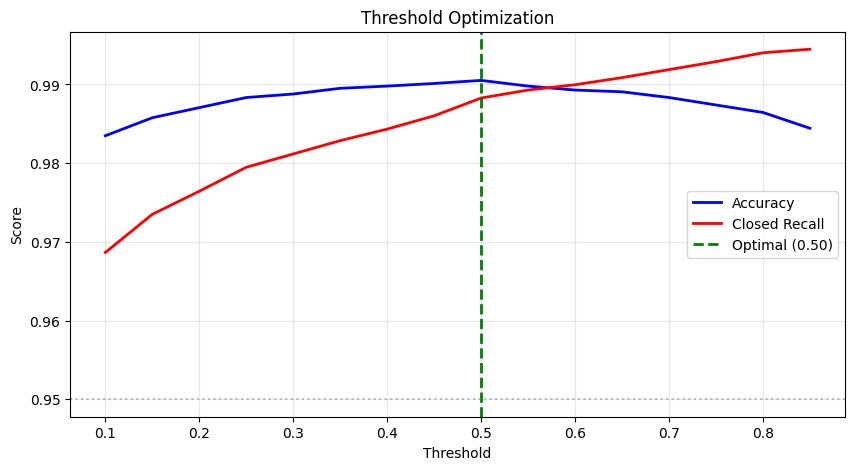

In [18]:
# Plot threshold analysis
plt.figure(figsize=(10, 5))
plt.plot([r['threshold'] for r in results], [r['accuracy'] for r in results], 'b-', lw=2, label='Accuracy')
plt.plot([r['threshold'] for r in results], [r['closed_recall'] for r in results], 'r-', lw=2, label='Closed Recall')
plt.axvline(x=OPTIMAL_THRESHOLD, color='green', linestyle='--', lw=2, label=f'Optimal ({OPTIMAL_THRESHOLD:.2f})')
plt.axhline(y=0.95, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Optimization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('threshold_v4.png', dpi=150)
plt.show()

## Part 10: Save Models

In [19]:
print("\n" + "="*50)
print("SAVING MODELS")
print("="*50)

model.save('eye_state_classifier_v4.keras')
print("✓ eye_state_classifier_v4.keras")

model.save('eye_state_classifier_v4.h5')
print("✓ eye_state_classifier_v4.h5")

model.save_weights('eye_state_classifier_v4_weights.weights.h5')
print("✓ eye_state_classifier_v4_weights.weights.h5")


SAVING MODELS
✓ eye_state_classifier_v4.keras
✓ eye_state_classifier_v4.h5
✓ eye_state_classifier_v4_weights.weights.h5


In [20]:
# Convert to TFLite
print("\nConverting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('eye_state_classifier_v4.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"✓ eye_state_classifier_v4.tflite ({len(tflite_model)/1024:.1f} KB)")


Converting to TFLite...
INFO:tensorflow:Assets written to: /tmp/tmp0gi9gbly/assets


INFO:tensorflow:Assets written to: /tmp/tmp0gi9gbly/assets


Saved artifact at '/tmp/tmp0gi9gbly'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133528981038160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868366928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868368656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868366736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868366160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868369616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868369040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868368272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868370576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868370768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133528868368080:

W0000 00:00:1766567738.917119      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1766567738.917152      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1766567738.945763      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [21]:
# Speed test
import time

dummy = np.random.rand(1, 64, 64, 1).astype(np.float32)
for _ in range(10):
    _ = model.predict(dummy, verbose=0)

start = time.time()
for _ in range(100):
    _ = model.predict(dummy, verbose=0)
avg_ms = (time.time() - start) / 100 * 1000

print(f"\nInference time: {avg_ms:.2f} ms" + (" ✅" if avg_ms < 50 else " ⚠️"))


Inference time: 55.81 ms ⚠️


## Part 11: Final Summary

In [22]:
test_acc = (y_pred == y_true).mean()

print("\n" + "="*70)
print("                    MODEL V4 SUMMARY")
print("="*70)
print(f"""
ARCHITECTURE: EyeClassifier_v4_Robust
  Parameters: {model.count_params():,}

KEY IMPROVEMENTS OVER V3:
  ✓ CLAHE applied during training (matches inference)
  ✓ Motion blur augmentation
  ✓ Partial occlusion augmentation
  ✓ Gaussian noise augmentation

RESULTS:
  Test Accuracy:      {test_acc*100:.2f}%
  Closed Eye Recall:  {closed_recall*100:.2f}%
  Miss Rate:          {fnr*100:.2f}%

DEPLOYMENT:
  Threshold:      {OPTIMAL_THRESHOLD:.2f}
  Inference:      {avg_ms:.2f}ms
  Use with:       main_v4_optimized.py
""")

if test_acc > 0.95 and closed_recall > 0.95:
    print("✅ MODEL READY FOR DEPLOYMENT")
elif test_acc > 0.90:
    print("⚠️ MODEL ACCEPTABLE - Test in real conditions")
else:
    print("❌ MODEL NEEDS IMPROVEMENT")
print("="*70)


                    MODEL V4 SUMMARY

ARCHITECTURE: EyeClassifier_v4_Robust
  Parameters: 313,825

KEY IMPROVEMENTS OVER V3:
  ✓ CLAHE applied during training (matches inference)
  ✓ Motion blur augmentation
  ✓ Partial occlusion augmentation
  ✓ Gaussian noise augmentation

RESULTS:
  Test Accuracy:      99.05%
  Closed Eye Recall:  98.83%
  Miss Rate:          1.17%

DEPLOYMENT:
  Threshold:      0.50
  Inference:      55.81ms
  Use with:       main_v4_optimized.py

✅ MODEL READY FOR DEPLOYMENT


## Download Files

Download these files:
1. `eye_state_classifier_v4.h5` - Main model
2. `eye_state_classifier_v4.tflite` - Optimized model

Then use with `main_v4_optimized.py` for inference.